# Classificação com Árvores de Decisão e Random Forest usando Pipeline

In [43]:
# Importação de bibliotecas
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler


path = "/content/drive/MyDrive/ml-project/data" #pasta do projeto
FILE = "smart-contract-dataset.csv" #nome do arquivo
SEED = 78 #seed para usar nas divisões de dados
CV_FOLDS = 5 #folds para cross validation
SCORING_METRIC = 'precision' #qual estimativa priorizar


## Carregamento dos dados (substitua pelo seu dataset)

In [44]:
data = pd.read_csv(os.path.join(FILE)) #carrega os dados

X = data.iloc[:, 3:].select_dtypes(include="number") #filtra as linhas numéricas a partir da col índex 3
y = data.label #filtra todas as linhas da coluna "label"

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

## Pipeline com Decision Tree priorizando o Recall

Melhores parâmetros para Decision Tree: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      5410
           1       0.44      0.61      0.52      1925

    accuracy                           0.70      7335
   macro avg       0.64      0.67      0.65      7335
weighted avg       0.74      0.70      0.71      7335



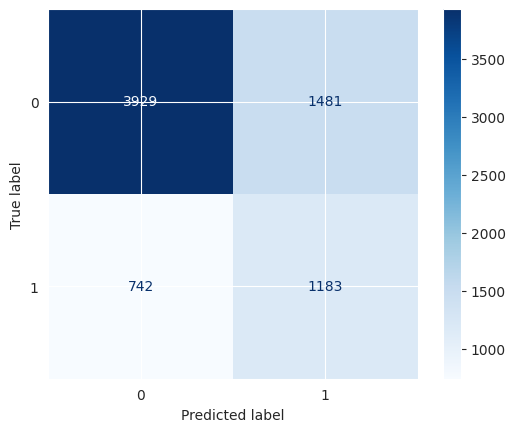

In [45]:
# Pipeline com Decision Tree e busca por hiperparâmetros que maximizem o recall
dt_pipeline = Pipeline([
    ('undersampler', RandomUnderSampler(sampling_strategy='auto', random_state=SEED)),
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=SEED))
])

# Definindo a grade de parâmetros para busca
dt_param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 10, 15, 20, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, scoring='recall', cv=5, n_jobs=-1)
dt_grid.fit(X_train, y_train)

# Avaliação
print("Melhores parâmetros para Decision Tree:", dt_grid.best_params_)
y_pred = dt_grid.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.show()


## Pipeline com Random Forest priorizando o Recall

Melhores parâmetros para Random Forest: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      5410
           1       0.49      0.76      0.59      1925

    accuracy                           0.73      7335
   macro avg       0.69      0.74      0.69      7335
weighted avg       0.79      0.73      0.74      7335



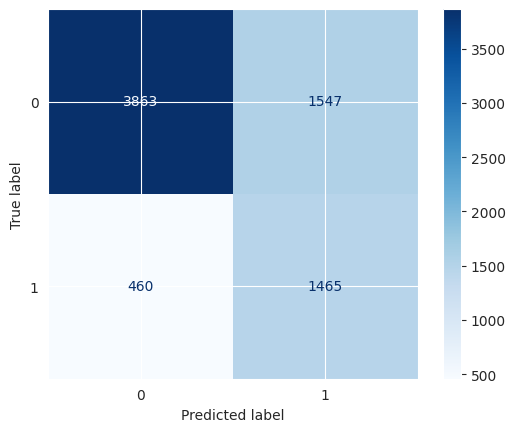

In [46]:
# Pipeline com Random Forest
rf_pipeline = Pipeline([
    ('undersampler', RandomUnderSampler(sampling_strategy='auto', random_state=SEED)),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Grade de parâmetros para Random Forest
rf_param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 5, 10, 15, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, scoring='recall', cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Avaliação
print("Melhores parâmetros para Random Forest:", rf_grid.best_params_)
y_pred_rf = rf_grid.predict(X_test)
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap="Blues")
plt.show()


## Aplicando PCA antes dos classificadores

In [47]:
# PCA com 95% da variância explicada
pca = PCA(n_components=0.70)
X_train_pca = pca.fit_transform(StandardScaler().fit_transform(X_train))
X_test_pca = pca.transform(StandardScaler().fit_transform(X_test))

print("Número de componentes após PCA:", X_train_pca.shape[1])


Número de componentes após PCA: 42


## Decision Tree após PCA

Melhores parâmetros DT com PCA: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      5410
           1       0.38      0.40      0.39      1925

    accuracy                           0.67      7335
   macro avg       0.58      0.58      0.58      7335
weighted avg       0.68      0.67      0.67      7335



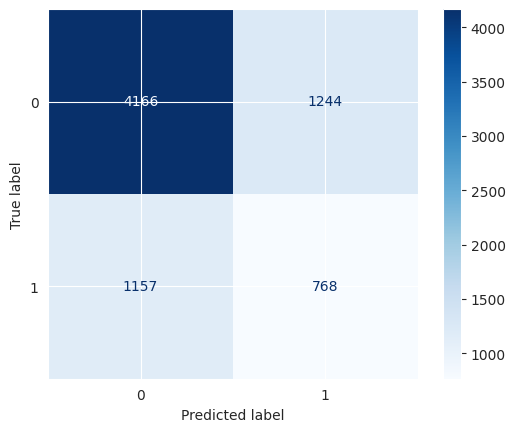

In [48]:
# Treinamento com PCA + Decision Tree
dt_pca_pipeline = Pipeline([
    ('clf', DecisionTreeClassifier(random_state=42))
])

dt_grid_pca = GridSearchCV(dt_pca_pipeline, {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}, scoring='recall', cv=5, n_jobs=-1)

dt_grid_pca.fit(X_train_pca, y_train)

print("Melhores parâmetros DT com PCA:", dt_grid_pca.best_params_)
y_pred_pca_dt = dt_grid_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred_pca_dt))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pca_dt, cmap="Blues")
plt.show()


## Random Forest após PCA

Melhores parâmetros RF com PCA: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 50}
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      5410
           1       0.66      0.27      0.38      1925

    accuracy                           0.77      7335
   macro avg       0.72      0.61      0.62      7335
weighted avg       0.75      0.77      0.73      7335



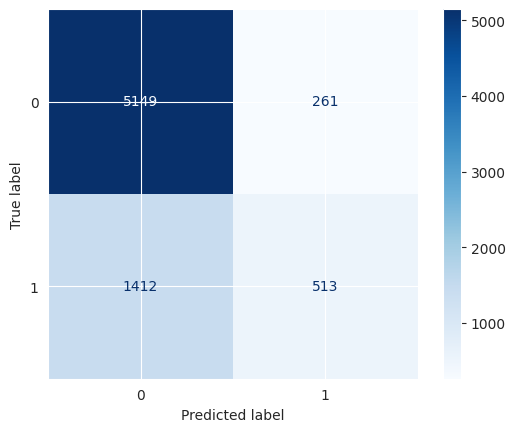

In [49]:
rf_pca_pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

rf_grid_pca = GridSearchCV(rf_pca_pipeline, {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}, scoring='recall', cv=5, n_jobs=-1)

rf_grid_pca.fit(X_train_pca, y_train)

print("Melhores parâmetros RF com PCA:", rf_grid_pca.best_params_)
y_pred_pca_rf = rf_grid_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred_pca_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pca_rf, cmap="Blues")
plt.show()
